# Library

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

# from astropy.cosmology import WMAP9 as cosmo
# from astropy.constants import c
# from astropy import units as u
# from astropy.cosmology import z_at_value
import inspect

import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


# Setting

In [2]:
snrcut = 3
source = 'salt3'
fittype = 'SNIa'

## Path

In [3]:
intype = 'kn'
indist = 40
inexptime = 180
group = 'med25nm'

In [4]:
path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
    os.makedirs(path_output)

print(f"Input  path:{path_input}")
print(f"Output path:{path_output}")

intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))

Input  path:../input/kn/040Mpc/180s/med25nm
Output path:../fit_result/kn2SNIa/040Mpc/180s/med25nm


## Output Table

In [5]:
outbl = Table()
#	Input data
outbl['input_table'] = [os.path.basename(intable) for intable in intablelist]
#	Detection / Fit
outbl['ndet'] = 0
outbl['det_filters'] = " "*200
outbl['det'] = False
outbl['fit'] = False
#	Fitted Parameters
outbl['t'] = 0.
outbl['x0'] = 0.
outbl['x1'] = 0.
outbl['c'] = 0.
#	Error
outbl['terr'] = 0.
outbl['x0err'] = 0.
outbl['x1err'] = 0.
outbl['cerr'] = 0.
#	Fit Results
outbl['free_params'] = 0
outbl['dof'] = 0
outbl['chisq'] = 0.
outbl['chisqdof'] = 0.
outbl['bic'] = 0.
#	Meta
outbl.meta['fittype'] = fittype
outbl.meta['source'] = source
outbl.meta['intype'] = intype
outbl.meta['indist[Mpc]'] = indist
outbl.meta['inexptime[s]'] = inexptime
outbl.meta['group'] = group
outbl.meta['date'] = Time.now().isot

In [6]:
#	Temp Table
_mdtbl = Table.read(intablelist[0])
for key, val in _mdtbl.meta.items():
    if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
        if type(val) is str:
            outbl[key] = ' '*10
        elif type(val) is float:
            outbl[key] = 0.0
        elif type(val) is int:
            outbl[key] = 0
        # print(key, val)

In [7]:
ii = 10
intable = intablelist[ii]
intbl = Table.read(intable, format='fits')

In [8]:
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

In [9]:
filterset = [f"{group}-{filte}" for filte, _, group in filterlist_med25nm if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

In [10]:
ndet = len(filterset)
print(f"number of detections: {ndet}")
detection = np.any(intbl['snr'] > 5)
print(f"detection: {detection}")

number of detections: 18
detection: True


- z, t, x0, x1, c

# Main

## Sample model

In [11]:
import sncosmo

- ['z', 't0', 'x0', 'x1', 'c']

In [12]:
model = sncosmo.Model(source)
model.param_names
#	phase
phasemin, phasemax = model.mintime(), model.maxtime()
phasearr = np.arange(phasemin, phasemax, 1)
#	wavelength
lammin, lammax = model.minwave(), model.maxwave()
lamarr = np.arange(lammin, lammax, 1)

In [13]:
def func(x, z, t, x0, x1, c):
	model.set(z=z, x0=x0, x1=x1, c=c)
	# model.set_source_peakabsmag(-19.0, 'bessellb', 'ab')
	#	Spectrum : wavelength & flux
	lam = np.arange(model.minwave(), model.maxwave(), 1)
	flam = model.flux(t, lam)

	#	Padding the spectrum
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(flam, lam))
	
	#	Magnitude from model spectrum
	spfnu = (np.array(list(mags[0]))*u.ABmag).to(u.uJy).value

	return spfnu

In [14]:
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

p0 = (
    0.01, 0, 0, 0, 0,
)

bounds = (
    (0.0, -np.inf, -np.inf, -np.inf, -np.inf),
    (1.0, np.inf, np.inf, np.inf, np.inf)
)

In [15]:
#	Default `fit`
fit = False
try:
	popt, pcov = curve_fit(
		func,
		xdata=xdata,
		ydata=ydata,
		sigma=sigma,
		p0=p0,
		absolute_sigma=True,
		check_finite=True,
		bounds=bounds,
		method='trf',
		# max_nfev=1e4,
	)
	fit = True
except Exception as e:
	# print(e)
	outlog = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'log')}"
	f = open(outlog, 'w')
	f.write(e)
	f.close()
	fit = False

In [16]:
# z, t, x0, x1, c
z = popt[0]
t = popt[1]
x0 = popt[2]
x1 = popt[3]
c = popt[4]

print(f"z ={z:.3}")
print(f"t ={t:.3}")
print(f"x0={x0:.3}")
print(f"x1={x1:.3}")
print(f"c ={c:.3}")

z =1.64e-31
t =-5.51
x0=0.000241
x1=1.89
c =0.255


In [17]:
#	Fitting result
r = ydata.data - func(xdata, *popt)
n_free_param = len(inspect.signature(func).parameters)-1
# ndet = len(xdata)
dof = ndet - n_free_param
chisq_i = (r / sigma) ** 2
chisq = np.sum(chisq_i)
chisqdof = chisq/dof
bic = chisq + n_free_param*np.log(ndet)
perr = np.sqrt(np.diag(pcov))

# print(chisq)
print(f"Reduced Chisq: {chisqdof:.3}")

Reduced Chisq: 2.51


## Result

In [18]:
outpng = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'png')}"
outfits = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit')}"

In [19]:
#	Detection / Fit
outbl['ndet'][ii] = ndet
outbl['det_filters'][ii] = filterlist_str
outbl['det'][ii] = detection
outbl['fit'][ii] = fit
#	Fitted Parameters
outbl['t'][ii] = t
outbl['x0'][ii] = x0
outbl['x1'][ii] = x1
outbl['c'][ii] = c
#	Error
outbl['terr'][ii] = perr[0]
outbl['x0err'][ii] = perr[1]
outbl['x1err'][ii] = perr[2]
outbl['cerr'][ii] = perr[3]
#	Fit Results
outbl['free_params'][ii] = n_free_param
outbl['dof'][ii] = dof
outbl['chisq'][ii] = chisq
outbl['chisqdof'][ii] = chisqdof
outbl['bic'][ii] = bic

In [20]:
#	Temp Table
for key, val in intbl.meta.items():
    if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
        outbl[key][ii] = val

In [21]:
outbl[ii]

input_table,ndet,det_filters,det,fit,t,x0,x1,c,terr,x0err,x1err,cerr,free_params,dof,chisq,chisqdof,bic,MD,VD,MW,VW,ANG,PHASE,REDSHIFT
str15,int64,str200,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
obs.000010.fits,18,"m4000,m4250,m4500,m4750,m5000,m5250,m5500,m5750,m6000,m6250,m6500,m6750,m7000,m7250,m7500,m7750,m8000,m8250",True,True,-5.506356834172548,0.00024123046116842568,1.8862072211762957,0.25500648862780506,0.005714777027444999,1.4201558188150203,2.0305261150509664e-05,0.7544484627238923,5,13,32.669944497946055,2.513072653688158,47.12180328742688,0.001,0.05,0.001,0.05,60,0.5,0.009183069776131852


## Figure

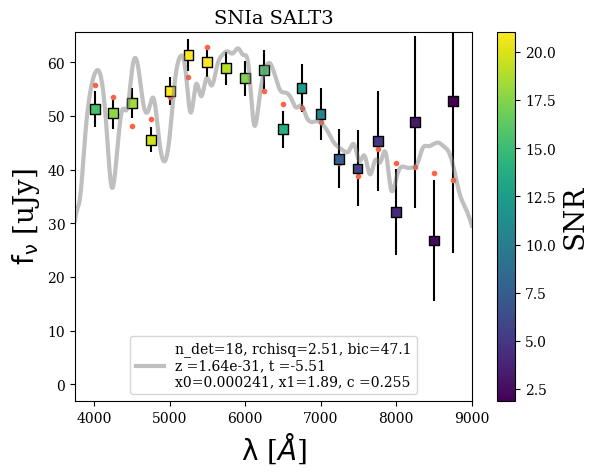

In [22]:
model.set(z=z, x0=x0, x1=x1, c=c)
flamarr = model.flux(t, lamarr)
fnuarr = convert_flam2fnu(flamarr*flamunit, lamarr*lamunit).to(u.uJy)

label = f"""n_det={ndet}, rchisq={chisqdof:.3}, bic={bic:.3}
z ={z:.3}, t ={t:.3}
x0={x0:.3}, x1={x1:.3}, c ={c:.3}"""

plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
# plt.scatter(bands.effective_wavelengths, xdata, c=intbl['snr'], marker='s', s=50, ec='k')
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
plt.errorbar(intbl['lam'], intbl['fnuobs'], yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
cbar = plt.colorbar()
cbar.set_label("SNR")
# plt.plot(bands.effective_wavelengths, func(xdata, *popt), '.', c='tomato')
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)
plt.title(f"{fittype} {source.upper()}")
plt.xlim([3750, 9000])
# yl, yu = plt.ylim()
# plt.ylim([0, yu])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.savefig(outpng, dpi=100)

In [ ]:
outbl.write(outfits, overwrite=True)